In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [4]:
import utils.pong
import utils.drnn_model
import utils.visualization
import utils.tf_helpers

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sacred

tf.__version__

'2.0.0'

In [5]:
ex = sacred.Experiment(name='DRNN-3L Experiment', interactive=True)

In [6]:
@ex.capture
def make_dataset(bs, W, H, SEQ_LEN):
    stateful_pong_generator = utils.pong.StatefulPongGenerator(W, H, SEQ_LEN)


    def data_input():
        for (d, c), (f, g) in stateful_pong_generator:
            stateful_pong_generator.stochasticity = np.random.uniform(0, 1)
            yield (d, c), f

    return tf.data.Dataset.from_generator(
        data_input,
        output_types=((tf.float32, tf.float32), tf.float32),
    ).take(8000).cache().repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
@ex.config
def config():
    SEQ_LEN = 256
    W, H = 40, 40
    internal_size = 32
    batch_size = 128
    steps_per_epoch = 128
    lr = 0.005
    weight_decay = 0.0001
    should_preload_model = True

In [8]:
def on_batch_begin(model):
    utils.visualization.plot_pairwise_frames(
        sampler=lambda: list(make_dataset(1).take(1))[0],
        hypotheses=lambda x: model.net.predict(x)[0]
    )
    
    if 'loss' in model.net.history.history:
        loss = model.net.history.history['loss'][-1]
        ex.log_scalar('loss', loss)

    pred_rollout_name = 'pred_rollout.png'
    plt.savefig(pred_rollout_name)
    ex.add_artifact(pred_rollout_name)
    plt.show()

In [9]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
    batch_size,
    steps_per_epoch,
    lr,
    weight_decay,
    should_preload_model,
):
    #### Model
    model = utils.drnn_model.DRNN(internal_size=internal_size, W=W, H=H, lr=lr, weight_decay=weight_decay)
    model.net.summary()

    model_img_name = 'model.png'
    tf.keras.utils.plot_model(model.net, to_file=model_img_name, show_shapes=True, expand_nested=False, rankdir='TB', dpi=90)
    ex.add_artifact(model_img_name)
    
    #### Callbacks
    callbacks = [
        utils.tf_helpers.model_persistor(
            model,
            should_preload_model=should_preload_model,
            cp_file_name='cp-drnn-{epoch:0004d}-{loss:.5f}.hdf5'
        ),
        utils.tf_helpers.on_batch_begin(lambda: on_batch_begin(model)),
        model.tb_callback,
    ]
    
    #### Training
    input_generator = make_dataset(bs=batch_size)
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=steps_per_epoch,
        epochs=2000,
        callbacks=callbacks
    )

WARNING - DRNN-3L Experiment - No observers have been added to this run
INFO - DRNN-3L Experiment - Running command 'main'
INFO - DRNN-3L Experiment - Started


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
polar_to_cartesian (Lambda)     (None, 2)            0           game_init[0][0]                  
__________________________________________________________________________________________________
space_to_batch_gru1 (Lambda)    (None, None, 2)      0           user_input[0][0]                 
______________________________________________________________________________________________

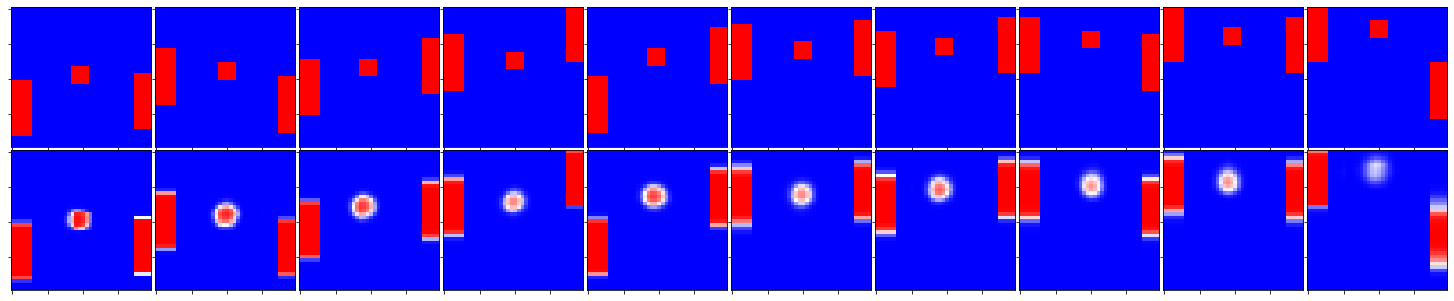

Epoch 1/2000
 15/128 [==>...........................] - ETA: 2:01 - loss: 0.0792 - mse: 0.0219

In [ ]:
# ex.observers.append(sacred.observers.MongoObserver())
ex.run(config_updates={'should_preload_model': True})

In [ ]:
x = tf.random.uniform((5, 10, 10, 1))
x = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2))(x)
x = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2))(x)
x.shape